# Introduction



In [1]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 5.5 MB/s 
     |████████████████████████████████| 131 kB 42.5 MB/s 
     |████████████████████████████████| 8.4 MB 45.2 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 138 kB 44.6 MB/s 
     |████████████████████████████████| 127 kB 50.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


100%|██████████| 231508/231508 [00:00<00:00, 2082494.09B/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Input Formatting
Because BERT is a pretrained model that expects input data in a specific format, we will need:

- special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
- tokens that conforms with the fixed vocabulary used in BERT
- token IDs from BERT's tokenizer
- mask IDs to indicate which elements in the sequence are tokens and which are padding elements
- segment IDs used to distinguish different sentences
- positional embeddings used to show token position within the sequence

Luckily, this interface takes care of some of these input specifications for us so we will only have to manually create a few of them (we'll revisit the other inputs in another tutorial).




## 2.2. Tokenization

In [4]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english'))
from nltk import tokenize
from operator import itemgetter
import math


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
df = pd.read_csv("/content/drive/MyDrive/conversation.csv")
df

,user1,user2,message,date
0,John,Rahul,To maintain a healthy diet is really important,20-11-2021
1,Rahul,John,I agree with you. But the worst part is that ...,20-11-2021
2,John,Rahul,Yeah. It happens.,20-11-2021
3,Rahul,John,I hope there was a solution to this,20-11-2021
4,John,Rahul,Ofcourse. You can choose many other options.,20-11-2021
5,Rahul,John,Like what?,20-11-2021
6,John,Rahul,Do you like fruits?,20-11-2021
7,Rahul,John,Yes. I do.,20-11-2021
8,John,Rahul,Fruits contain many nutrients. And it may help...,20-11-2021
9,Rahul,John,Yeah. I haven't thought about it yet.,20-11-2021


In [6]:
df=df.dropna()
df["message"]=df["message"].str.lower()
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user1,user2,message,date
0,John,Rahul,to maintain a healthy diet is really important,20-11-2021
1,Rahul,John,i agree with you. but the worst part is that ...,20-11-2021
2,John,Rahul,yeah. it happens.,20-11-2021
3,Rahul,John,i hope there was a solution to this,20-11-2021
4,John,Rahul,ofcourse. you can choose many other options.,20-11-2021
5,Rahul,John,like what?,20-11-2021
6,John,Rahul,do you like fruits?,20-11-2021
7,Rahul,John,yes. i do.,20-11-2021
8,John,Rahul,fruits contain many nutrients. and it may help...,20-11-2021
9,Rahul,John,yeah. i haven't thought about it yet.,20-11-2021


In [7]:
query=input("What you want to know :")
words = tokenizer.tokenize(query)
keywords=[]
for i in words:
  if len(i)>3:
    keywords.append(i)

What you want to know :what was the conversation regarding apple phone?


In [8]:
keywords

['what', 'conversation', 'regarding', 'apple', 'phone']

In [9]:
df_new = df[df['user1'] == 'John']
results=[]    
for i in df_new["message"]:
  if "apple" in i:    
    results.append(i)

results.append(query)
print(results)  
res = '. '.join(map(str, results))
res

['i actually love apples', 'apple iphone, macbook, airpod, airbook', 'we do have different models of apple phones with us', 'what was the conversation regarding apple phone?']


'i actually love apples. apple iphone, macbook, airpod, airbook. we do have different models of apple phones with us. what was the conversation regarding apple phone?'

In [10]:

# Add the special tokens.
marked_text = "[CLS] " + res + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))
    

[CLS]           101
i             1,045
actually      2,941
love          2,293
apples       18,108
.             1,012
apple         6,207
iphone       18,059
,             1,010
mac           6,097
##book        8,654
,             1,010
air           2,250
##pod        27,633
,             1,010
air           2,250
##book        8,654
.             1,012
we            2,057
do            2,079
have          2,031
different     2,367
models        4,275
of            1,997
apple         6,207
phones       11,640
with          2,007
us            2,149
.             1,012
what          2,054
was           2,001
the           1,996
conversation  4,512
regarding     4,953
apple         6,207
phone         3,042
?             1,029
[SEP]           102


In [11]:
# Mark each of the tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# 3. Extracting Embeddings 



## 3.1. Running BERT on our text

Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.
 
model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

Calling `from_pretrained` will fetch the model from the internet. When we load the `bert-base-uncased`, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

In [12]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


100%|██████████| 407873900/407873900 [00:11<00:00, 35980786.79B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

Next, let's fetch the hidden states of the network.

torch.no_grad deactivates the gradient calculations, saves memory, and speeds up computation (we don't need gradients or backpropagation since we're just running a forward pass). 


In [13]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [14]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 38
Number of hidden units: 768


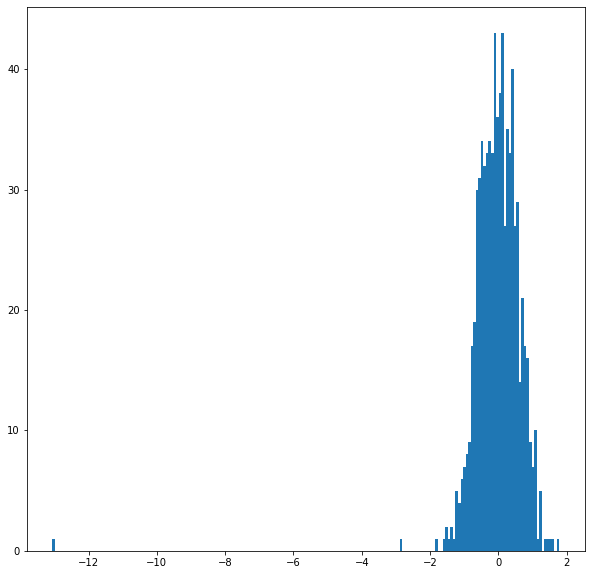

In [15]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token. 

Current dimensions:

`[# layers, # batches, # tokens, # features]`

Desired dimensions:

`[# tokens, # layers, # features]`

Luckily, PyTorch includes the `permute` function for easily rearranging the dimensions of a tensor. 

However, the first dimension is currently a Python list! 

In [16]:
# `encoded_layers` is a Python list.
print('     Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 38, 768])


Let's combine the 12 layers to make this one whole big tensor.

In [17]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)

token_embeddings.size()

torch.Size([12, 1, 38, 768])

Let's get rid of the "batches" dimension since we don't need it.

In [18]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([12, 38, 768])

Finally, we can switch around the "layers" and "tokens" dimensions with `permute`.

In [19]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([38, 12, 768])

In [20]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 38 x 3072


As an alternative method, let's try creating the word vectors by **summing** together the last four layers.

In [21]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 38 x 768


### Sentence Vectors

To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [22]:
# `encoded_layers` has shape [12 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [23]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


In [24]:
tokenized_text

['[CLS]',
 'i',
 'actually',
 'love',
 'apples',
 '.',
 'apple',
 'iphone',
 ',',
 'mac',
 '##book',
 ',',
 'air',
 '##pod',
 ',',
 'air',
 '##book',
 '.',
 'we',
 'do',
 'have',
 'different',
 'models',
 'of',
 'apple',
 'phones',
 'with',
 'us',
 '.',
 'what',
 'was',
 'the',
 'conversation',
 'regarding',
 'apple',
 'phone',
 '?',
 '[SEP]']

In [25]:
s = ''
for i,j in enumerate(tokenized_text):
  #print(j)
  s = s +' ' +j
  #s = i + ''.join(i)
print(s)

 [CLS] i actually love apples . apple iphone , mac ##book , air ##pod , air ##book . we do have different models of apple phones with us . what was the conversation regarding apple phone ? [SEP]


In [26]:
 s = s.split('.')
 s

[' [CLS] i actually love apples ',
 ' apple iphone , mac ##book , air ##pod , air ##book ',
 ' we do have different models of apple phones with us ',
 ' what was the conversation regarding apple phone ? [SEP]']

In [38]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)


0 [CLS]
1 i
2 actually
3 love
4 apples
5 .
6 apple
7 iphone
8 ,
9 mac
10 ##book
11 ,
12 air
13 ##pod
14 ,
15 air
16 ##book
17 .
18 we
19 do
20 have
21 different
22 models
23 of
24 apple
25 phones
26 with
27 us
28 .
29 what
30 was
31 the
32 conversation
33 regarding
34 apple
35 phone
36 ?
37 [SEP]


In [39]:
print('First 5 vector values for each instance of "apple".')
print('')
print("love apples   ", str(token_vecs_sum[4][:5]))
print("apple iphone  ", str(token_vecs_sum[6][:5]))
print("apple phones   ", str(token_vecs_sum[24][:5]))
print("apple phone   ", str(token_vecs_sum[34][:5]))

First 5 vector values for each instance of "apple".

love apples    tensor([-0.0389,  3.4002, -0.8703, -1.2919,  5.9360])
apple iphone   tensor([ 1.7225,  5.9177,  0.9214, -1.2963,  4.1716])
apple phones    tensor([1.1474, 3.3373, 0.0417, 2.1154, 4.0478])
apple phone    tensor([1.6775, 3.1633, 0.4659, 0.3017, 4.3404])


We can see that the values differ, but let's calculate the cosine similarity between the vectors to make a more precise comparison.

In [31]:
from scipy.spatial.distance import cosine

list = []
diff = 1 - cosine(token_vecs_sum[4], token_vecs_sum[34])
list.append(diff)
same1 = 1 - cosine(token_vecs_sum[24], token_vecs_sum[34])
list.append(same1)
same = 1 - cosine(token_vecs_sum[6], token_vecs_sum[34])
list.append(same)
print('Vector similarity for  *similar*  meanings:  %.2f' % same1)
print('Vector similarity for  *similar*  meanings:  %.2f' % same)
print('Vector similarity for *different* meanings:  %.2f' % diff)


Vector similarity for  *similar*  meanings:  0.85
Vector similarity for  *similar*  meanings:  0.74
Vector similarity for *different* meanings:  0.58


In [32]:
list

[0.5761598348617554, 0.8513855338096619, 0.7413013577461243]

In [33]:
max(list)

0.8513855338096619

In [34]:
s[1]

' apple iphone , mac ##book , air ##pod , air ##book '

In [35]:
for i in list:
  print(i)

0.5761598348617554
0.8513855338096619
0.7413013577461243


In [36]:
list.index(max(list))

1

In [37]:
for i in range(3):
    if i == list.index(max(list)):
      print("The most similar sentence is: ",s[i])

The most similar sentence is:   apple iphone , mac ##book , air ##pod , air ##book 
